In [ ]:
import pandas as pd
import numpy as np
import torch
import re

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

import string, re, nltk
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords


In [ ]:
## load the data
df=pd.read_csv('/content/assignment_data_res_com.csv',index_col=0)
df

,masked_address,label
id,,
2,"JAI BALAJI DISTRIBUTORS, NEW MARKET SHOP NO.**...",commercial
423,SUNDRAM FASTENERS LIMITED B ** SIPCOT INDUSTRI...,commercial
481,"Bakul-*, Shardashish Township, Torrent Power L...",commercial
641,"Sonkar Bhawan, Near Ashok Kirana Store, Infron...",commercial
4395,"jambli \n maida factory near jambli , jambli,...",commercial
...,...,...
10596,"A. Rajeshwari, No.***, Pampatti street, East g...",NaN
10597,"Flat no ***,S.V's srinivasam, nehrunagar , HY...",NaN
10598,"Madhav nagar katni, Near post office road , M...",NaN


In [ ]:
## EDA for labelled data


In [ ]:
# Missing values and duplicate address?
print(pd.Series({"Number of observations with missing values": len(df['masked_address']) - len(df['masked_address'].dropna()),
                 "Number of duplicate observations": df['masked_address'].duplicated().sum()}).to_string())

Number of observations with missing values    0
Number of duplicate observations              0


In [ ]:
# Manual encoding of labels
label_dict = {'commercial': 0, 'residential': 1}
df.replace({'label': label_dict}, inplace = True)


In [ ]:
# Splitting the dataset by label
data_c = df[df['label'] == 0] # commerical
data_r = df[df['label'] == 1] # residential

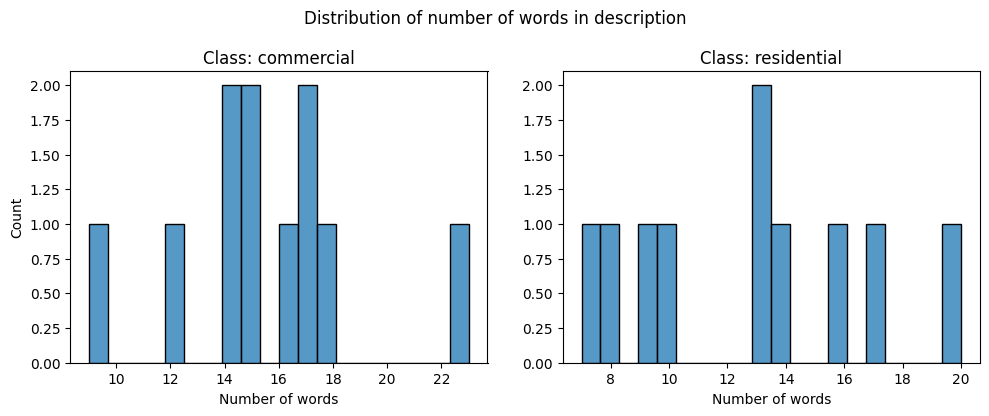

In [ ]:
# Distribution of number of words in description
data_c_word = data_c['masked_address'].str.split().map(lambda x: len(x))
data_r_word = data_r['masked_address'].str.split().map(lambda x: len(x))

fig, ax = plt.subplots(1, 2, figsize=(10, 4.2), sharey=False)
sns.histplot(x=data_c_word, bins=20, ax=ax[0]).set_title('Class: commercial')
sns.histplot(x=data_r_word, bins=20, ax=ax[1]).set_title('Class: residential')

fig.suptitle("Distribution of number of words in description")

for i in range(2):
    ax[i].set_xlabel("Number of words")
    if i != 0:
        ax[i].set_ylabel(" ")

plt.tight_layout()
plt.show()



In [ ]:
## Text Normalisation/Pre-processing


In [ ]:
# Converting to lowercase
df['masked_address'] = df['masked_address'].str.lower()

In [ ]:
## remove emails
def remove_custom_emails(text):
    # Pattern to remove emails with various masking
    custom_email_pattern = r'[A-Za-z0-9.*_%-]+@(?:gmail\.com|yahoo\.com|hotmail\.com|outlook\.com)'
    return re.sub(custom_email_pattern, '', text)


df['masked_address']=df['masked_address'].apply(remove_custom_emails)


In [ ]:

# Remove all special characters except * and $ (masks) and /

def clean_special_characters(text):
    return re.sub(r'[^\w\s*$/]', ' ', text)

df['masked_address']=df['masked_address'].apply(clean_special_characters)

In [ ]:
# Function to normalize spacing
def normalize_spacing(text):
    # Replace multiple spaces with a single space
    return re.sub(r'\s+', ' ', text).strip()


df['masked_address'] = df['masked_address'].apply(normalize_spacing)

In [ ]:
# Function to remove consecutive duplicate words
def remove_consecutive_duplicates(text):
    # Regex pattern to match consecutive duplicate words
    pattern = r'\b(\w+)\s+\1\b'
    # Replace consecutive duplicate words with a single instance
    return re.sub(pattern, r'\1', text)

df['masked_address'] = df['masked_address'].apply(remove_consecutive_duplicates)


In [ ]:
# Function to remove all occurrences of duplicate words irrespective of consecutive or not
def remove_all_duplicates(text):
    words = text.split()
    seen = set()
    result = []
    for word in words:
        # Check if the word is already in the seen set
        if word.lower() not in seen:
            seen.add(word.lower())
            result.append(word)
    return ' '.join(result)

df['masked_address'] = df['masked_address'].apply(remove_all_duplicates)


In [ ]:
#df.to_csv('c:/Users/Anjali/Downloads/Assignment/assignment_cleaned.csv')

In [ ]:
# ## Probabilistic splitting
# def probabilistic_split(token, term_freq_dict):
#     # Check if the token is masked
#     if '$' in token or '*' in token:
#         return token, None

#     n = len(token)
#     for i in range(1, n):
#         token1, token2 = token[:i], token[i:]
#         # Check if the split tokens have a higher combined frequency
#         if term_freq_dict[token1] > 0 and term_freq_dict[token2] > 0:
#             if term_freq_dict[token1] + term_freq_dict[token2] > term_freq_dict[token]:
#                 return token1, token2
#     return token, None


In [ ]:
# Create term-frequency dictionary
term_freq_dict = defaultdict(int)
for address in df['masked_address']:
    tokens = address.split()
    for token in tokens:
        term_freq_dict[token] += 1

In [ ]:

# # Split each address based on probabilistic splitting
# def split_address(address, term_freq_dict):
#     tokens = address.split()
#     split_tokens = []
#     for token in tokens:
#         token1, token2 = probabilistic_split(token, term_freq_dict)
#         split_tokens.append(token1)
#         if token2:
#             split_tokens.append(token2)
#     return ' '.join(split_tokens)


# df['processed_address'] = df['masked_address'].apply(lambda x: split_address(x, term_freq_dict))

# print(df[['masked_address', 'processed_address']])

In [ ]:
# # pyspellchecker
# spell = SpellChecker()

# def pyspellchecker(text):
#     word_list = regexp.tokenize(text)
#     word_list_corrected = []
#     for word in word_list:
#         if word in spell.unknown(word_list):
#             word_corrected = spell.correction(word)
#             if word_corrected == None:
#                 word_list_corrected.append(word)
#             else:
#                 word_list_corrected.append(word_corrected)
#         else:
#             word_list_corrected.append(word)
#     text_corrected = " ".join(word_list_corrected)
#     return text_corrected

# text = "Rajpur Road dehradun,uttrakhand"
# print("Input: {}".format(text))
# print("Output: {}".format(pyspellchecker(text)))

In [ ]:
#df.to_csv('c:/Users/Anjali/Downloads/Assignment/df_corrected_spell.csv')

In [ ]:
### tokenisation with WOrd2vec and weighing with TF-IDF

## Tokens and vector of the tokenised address
#The final vector is normalized to unit length of 100 which help in training the algorithm.
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Step 1: Tokenize addresses
def tokenize_address(address):
    # Keep PIN codes as single tokens
    address = re.sub(r'(\d{6})', r' \1 ', address)
    # Tokenize the rest while keeping * and $
    #tokens = re.findall(r'\*\*+|\$\$+|\w+', address)
    ## can better it later idea is to preserve * and $ associated text and / represents some number fromat
    tokens = re.findall(r'c\/o|\*\*+|\$\$+|\w+\/\w+|\w+\/\*+|\*+\/\*+|\*+\/\w+|\w+', address)
    return tokens

# def tokenize_address(address):
#     # Updated regex pattern to match **, $$, c/o, and sequences with /
#     tokens = re.findall(r'\*\*\/\*|\$\$+|c\/o|\*+\/\*+|\w+', address)
#     return tokens

df['tokens'] = df['masked_address'].apply(tokenize_address)

# Step 2: Compute TF-IDF weights
corpus = df['masked_address']
vectorizer = TfidfVectorizer(tokenizer=tokenize_address)
X = vectorizer.fit_transform(corpus)
tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

# Step 3: Train Word2Vec model
tokens = df['tokens'].tolist()
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Generate address vectors using TF-IDF


def get_weighted_avg_vector(tokens, tfidf_dict, w2v_model):
    vector_sum = np.zeros(w2v_model.vector_size)
    total_weight = 0
    for token in tokens:
        if token in w2v_model.wv:
            weight = tfidf_dict.get(token, 1.0)  # Default weight 1.0 for unseen tokens
            vector_sum += w2v_model.wv[token] * weight
            total_weight += weight
    if total_weight == 0:
        return np.zeros(w2v_model.vector_size)  # Return zero vector instead of None
    weighted_vector = vector_sum / total_weight
    return weighted_vector / np.linalg.norm(weighted_vector)  # Normalize to unit length

df['address_vector'] = df['tokens'].apply(lambda x: get_weighted_avg_vector(x, tfidf_dict, w2v_model))

print(df[['masked_address', 'address_vector']])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                          masked_address  \
id                                                         
2      jai balaji distributors new market shop no ** ...   
423    sundram fasteners limited b ** sipcot industri...   
481    bakul * shardashish township torrent power lim...   
641    sonkar bhawan near ashok kirana store infront ...   
4395        jambli maida factory near maharashtra 416121   
...                                                  ...   
10596  a rajeshwari no *** pampatti street east gate ...   
10597  flat no *** s v srinivasam nehrunagar hyderaba...   
10598  madhav nagar katni near post office road murwa...   
10599  mig ** sri sai * men s pg road no kphb colony ...   
10600  *th mile tadong near sikkim milk union new hot...   

                                          address_vector  
id                                                        
2      [-0.06931223549757207, 0.11700991654848282, 0....  
423    [-0.0619900122260751, 0.14758910422

In [ ]:
df

,masked_address,label,tokens,address_vector
id,,,,
2,jai balaji distributors new market shop no ** ...,0.0,"[jai, balaji, distributors, new, market, shop,...","[-0.06931223549757207, 0.11700991654848282, 0...."
423,sundram fasteners limited b ** sipcot industri...,0.0,"[sundram, fasteners, limited, b, **, sipcot, i...","[-0.0619900122260751, 0.14758910422086188, -0...."
481,bakul * shardashish township torrent power lim...,0.0,"[bakul, shardashish, township, torrent, power,...","[-0.07083080284310861, 0.14458166870855566, -0..."
641,sonkar bhawan near ashok kirana store infront ...,0.0,"[sonkar, bhawan, near, ashok, kirana, store, i...","[-0.07039106557285, 0.14437521573040477, -0.00..."
4395,jambli maida factory near maharashtra 416121,0.0,"[jambli, maida, factory, near, maharashtra, 41...","[-0.06386423349870973, 0.14849421964728765, 0...."
...,...,...,...,...
10596,a rajeshwari no *** pampatti street east gate ...,NaN,"[a, rajeshwari, no, ***, pampatti, street, eas...","[-0.06445098798100472, 0.14036478529048133, -0..."
10597,flat no *** s v srinivasam nehrunagar hyderaba...,NaN,"[flat, no, ***, s, v, srinivasam, nehrunagar, ...","[-0.07216214826157326, 0.1010708390363707, 0.0..."
10598,madhav nagar katni near post office road murwa...,NaN,"[madhav, nagar, katni, near, post, office, roa...","[-0.07936569826737797, 0.15118979964838652, -0..."


In [ ]:
## Additional Features depending on presence of some common keywoeds representing each class
# Adding features based on keywords
commercial_keywords = r'\bdistributors\b|\bfactory\b|\bwarehouse\b|\bindustrial\b|\bgodown\b|\bcomplex\b|\bpvt ltd\b'
residential_keywords = r'\bhouse\b|\bflat\b|\bstreet\b|\bcolony\b|\bbungalow\b'

df['is_residential'] = df['masked_address'].str.contains(residential_keywords, case=False, regex=True).astype(int)
df['is_commercial'] = df['masked_address'].str.contains(commercial_keywords, case=False, regex=True).astype(int)



In [ ]:
## Simpler model logistic regression and as labelled data is less expanding high confidence predictions as training set

# import numpy as np
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# # Convert lists of vectors to NumPy arrays
# X_train_labeled = np.array(df['address_vector'].iloc[:20].tolist())
# y_train_labeled = np.array(df['label'].iloc[:20].tolist())
# X_unlabeled = np.array(df['address_vector'].iloc[20:].tolist())

# # Initial model training
# initial_model = LogisticRegression(max_iter=1000)  # Ensure convergence
# initial_model.fit(X_train_labeled, y_train_labeled)

# # Predict on unlabeled data
# y_pred_proba = initial_model.predict_proba(X_unlabeled)
# high_confidence_indices = np.where(y_pred_proba.max(axis=1) > 0.5)[0]

# # Check if there are any high-confidence predictions
# if len(high_confidence_indices) > 0:
#     # Select high-confidence predictions
#     X_high_confidence = X_unlabeled[high_confidence_indices]
#     y_high_confidence = np.argmax(y_pred_proba[high_confidence_indices], axis=1)

#     # Combine high-confidence predictions with labeled data
#     X_combined = np.vstack((X_train_labeled, X_high_confidence))
#     y_combined = np.hstack((y_train_labeled, y_high_confidence))

#     # Retrain model
#     final_model = RandomForestClassifier()
#     final_model.fit(X_combined, y_combined)

#     # Evaluate final model on the labeled data
#     y_final_pred = final_model.predict(X_train_labeled)
#     print(classification_report(y_train_labeled, y_final_pred))
# else:
#     print("No high-confidence predictions found.")


In [ ]:
## Tried Label Propagarion
# from sklearn.semi_supervised import LabelPropagation

# # Combine labeled and unlabeled data
# X_combined = np.vstack((X_train_labeled, X_unlabeled))
# y_combined = np.hstack((y_train_labeled, -1 * np.ones(len(X_unlabeled))))

# # Train Label Propagation model
# label_prop_model = LabelPropagation(kernel='knn', n_neighbors=10)
# label_prop_model.fit(X_combined, y_combined)


In [ ]:
# y_pred = label_prop_model.predict(X_unlabeled)


In [ ]:
# cnt=0
# for i in y_pred:
#     if i<=00:
#         cnt+=1

# cnt

In [ ]:
# # With address_vectors as features trying random forest and as labelled data is less expanding high confidence predictions as training set learning in a self supervised fashion

# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import StandardScaler



# # Step 1: Prepare labeled data
# labeled_data = df[df['label'].notna()]
# unlabeled_data = df[df['label'].isna()]

# X_labeled = np.stack(labeled_data['address_vector'].values)
# y_labeled = labeled_data['label']

# # Step 2: Split labeled data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)


# model = RandomForestClassifier(random_state=42)
# model.fit(X_train, y_train)

# # Evaluate on validation set
# val_predictions = model.predict(X_val)
# print("Initial model performance:")
# print(classification_report(y_val, val_predictions))

# # Step 3: Semi-supervised learning
# confidence_threshold = 0.8
# X_unlabeled = np.stack(unlabeled_data['address_vector'].values)


# unlabeled_predictions = model.predict(X_unlabeled)
# unlabeled_probabilities = model.predict_proba(X_unlabeled)

# high_confidence_mask = np.max(unlabeled_probabilities, axis=1) > confidence_threshold
# high_confidence_predictions = unlabeled_predictions[high_confidence_mask]

# # Add high-confidence predictions to the training set
# X_train_expanded = np.vstack([X_train, X_unlabeled[high_confidence_mask]])
# y_train_expanded = np.concatenate([y_train, high_confidence_predictions])

# # Step 5: Retrain model
# model_expanded = RandomForestClassifier(random_state=42)
# model_expanded.fit(X_train_expanded, y_train_expanded)

# # Evaluate expanded model
# val_predictions_expanded = model_expanded.predict(X_val)
# print("\nExpanded model performance:")
# print(classification_report(y_val, val_predictions_expanded))

# # Make predictions on the entire dataset
# X_all = np.stack(df['address_vector'].values)
# # X_all_scaled = scaler.transform(X_all)
# final_predictions = model_expanded.predict(X_all)

# # Add predictions to the DataFrame
# df['predicted_label'] = final_predictions

# df['predicted_label']

In [ ]:
## With address_vectors along with keyword based features defined above
# trying random forest and as labelled data is less expanding high confidence predictions as training set learning in a self supervised fashion

# 20% of labelled data as test for intial evaluation and tehn predictions as predicted_label

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report



# Step 1: Prepare labeled data
labeled_data = df[df['label'].notna()]
unlabeled_data = df[df['label'].isna()]

# Convert categorical columns to numeric features
labeled_data['is_residential'] = labeled_data['is_residential'].astype(int)
labeled_data['is_commercial'] = labeled_data['is_commercial'].astype(int)

unlabeled_data['is_residential'] = unlabeled_data['is_residential'].astype(int)
unlabeled_data['is_commercial'] = unlabeled_data['is_commercial'].astype(int)

# Prepare feature matrices
X_labeled = np.hstack([
    np.stack(labeled_data['address_vector'].values),
    labeled_data[['is_residential', 'is_commercial']].values
])
y_labeled = labeled_data['label']

X_unlabeled = np.hstack([
    np.stack(unlabeled_data['address_vector'].values),
    unlabeled_data[['is_residential', 'is_commercial']].values
])

# Step 2: Split labeled data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Initial model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = model.predict(X_val)
print("Initial model performance:")
print(classification_report(y_val, val_predictions))

# Step 3: Semi-supervised learning
confidence_threshold = 0.8

unlabeled_predictions = model.predict(X_unlabeled)
unlabeled_probabilities = model.predict_proba(X_unlabeled)

high_confidence_mask = np.max(unlabeled_probabilities, axis=1) > confidence_threshold
high_confidence_predictions = unlabeled_predictions[high_confidence_mask]

# Add high-confidence predictions to the training set
X_train_expanded = np.vstack([X_train, X_unlabeled[high_confidence_mask]])
y_train_expanded = np.concatenate([y_train, high_confidence_predictions])

# Retrain model
model_expanded = RandomForestClassifier(random_state=42,n_estimators=200,max_depth=5)
model_expanded.fit(X_train_expanded, y_train_expanded)

# Evaluate expanded model
val_predictions_expanded = model_expanded.predict(X_val)
print("\nExpanded model performance:")
print(classification_report(y_val, val_predictions_expanded))

# Make predictions on the entire dataset
X_all = np.hstack([
    np.stack(df['address_vector'].values),
    df[['is_residential', 'is_commercial']].values
])
final_predictions = model_expanded.predict(X_all)

# Add predictions to the DataFrame
df['predicted_label_rf'] = final_predictions



<ipython-input-72-9b8bf94ddd40>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['is_residential'] = labeled_data['is_residential'].astype(int)
<ipython-input-72-9b8bf94ddd40>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data['is_commercial'] = labeled_data['is_commercial'].astype(int)
<ipython-input-72-9b8bf94ddd40>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Initial model performance:
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5


Expanded model performance:
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X_labeled, y_labeled, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.6  0.75 0.5  1.   0.5 ]
Mean CV score: 0.67


In [ ]:
print(f"Number of high-confidence samples added: {np.sum(high_confidence_mask)}")


Number of high-confidence samples added: 8481


In [ ]:
#Inference: on the limited labeled data we see that expanding teh training set with high confidence is also not helping betetr the predictions,tried with different threshols of confidence interval at 0.5 we see change
# it reflects that there are very lesss high confidence predictions through above method
## the predictions by the above model are labelled predicted_label_rf which can be evaluated if the original labels are provided for the rest of the data.
df['predicted_label_rf']

,predicted_label_rf
id,
2,0.0
423,1.0
481,0.0
641,0.0
4395,0.0
...,...
10596,1.0
10597,0.0
10598,1.0


In [ ]:
len(X_train_expanded)

3645

## BiLSTM approach

The second approach is to use the pre-processed data of the addresess as sequences and use a Bi-LSTM as it has an added advantage to capture both the
left and right context in case of text classification. The training is done in a similr fashion of self supervised learning expanding the training set with high confidence predictions.

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split

# # Prepare data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df['masked_address'])
# sequences = tokenizer.texts_to_sequences(df['masked_address'])

# # Pad sequences
# max_length = max(len(seq) for seq in sequences)
# padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# # Prepare labeled data
# X_labeled = padded_sequences[df['label'].notna()]
# y_labeled = df['label'].dropna().values

# # Split into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# # Build the model
# vocab_size = len(tokenizer.word_index) + 1
# embedding_dim = 100

# inputs = Input(shape=(max_length,))
# x = Embedding(vocab_size, embedding_dim)(inputs)
# x = Bidirectional(LSTM(64, return_sequences=True))(x)
# x = Bidirectional(LSTM(32))(x)
# outputs = Dense(1, activation='sigmoid')(x)

# model_lstm= Model(inputs, outputs)
# model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# # Evaluate the model
# val_loss, val_accuracy = model_lstm.evaluate(X_val, y_val)
# print(f"Validation Accuracy: {val_accuracy}")

# # Make predictions on unlabeled data
# X_unlabeled = padded_sequences[df['label'].isna()]
# unlabeled_predictions = model_lstm.predict(X_unlabeled)

# # Add high-confidence predictions to training set
# confidence_threshold = 0.8
# high_confidence_mask = np.abs(unlabeled_predictions - 0.5) > (confidence_threshold - 0.5)
# high_confidence_predictions = (unlabeled_predictions[high_confidence_mask] > 0.5).astype(int)

# X_train_expanded = np.vstack([X_train, X_unlabeled[high_confidence_mask.flatten()]])
# y_train_expanded = np.concatenate([y_train, high_confidence_predictions.flatten()])

# # Retrain the model with expanded dataset
# model_lstm.fit(X_train_expanded, y_train_expanded, epochs=5, batch_size=32)


# # Make final predictions
# final_predictions = model_lstm.predict(padded_sequences)
# df['predicted_label_bilstm'] = (final_predictions > 0.5).astype(int)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['masked_address'])
sequences = tokenizer.texts_to_sequences(df['masked_address'])

# Pad sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare labeled data
labeled_data = df[df['label'].notna()]
unlabeled_data = df[df['label'].isna()]

X_labeled = padded_sequences[df['label'].notna()]
y_labeled = df['label'].dropna().values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Build the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

inputs = Input(shape=(max_length,))
x = Embedding(vocab_size, embedding_dim)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)
outputs = Dense(1, activation='sigmoid')(x)

model_lstm = Model(inputs, outputs)
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model
val_loss, val_accuracy = model_lstm.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

# Make predictions on unlabeled data
X_unlabeled = padded_sequences[df['label'].isna()]
unlabeled_predictions = model_lstm.predict(X_unlabeled)

# Convert predictions to labels
confidence_threshold = 0.8            # at 0.6 threshold we see some change in X_train_expanded hence low confidence predictions
high_confidence_mask = np.abs(unlabeled_predictions - 0.5) > (confidence_threshold - 0.5)
high_confidence_predictions = (unlabeled_predictions[high_confidence_mask] > 0.5).astype(int)

# Debugging information
print(f"Initial X_train shape: {X_train.shape}")
print(f"Number of high-confidence samples: {np.sum(high_confidence_mask)}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"High-confidence X_unlabeled shape: {X_unlabeled[high_confidence_mask.flatten()].shape}")

# Expand training set
X_train_expanded = np.vstack([X_train, X_unlabeled[high_confidence_mask.flatten()]])
y_train_expanded = np.concatenate([y_train, high_confidence_predictions.flatten()])

print(f"X_train_expanded shape: {X_train_expanded.shape}")

# Retrain the model with expanded dataset
model_lstm.fit(X_train_expanded, y_train_expanded, epochs=5, batch_size=32)

# Make final predictions
final_predictions = model_lstm.predict(padded_sequences)
df['predicted_label_bilstm'] = (final_predictions > 0.5).astype(int)

# Print the updated classification report
print("Updated Classification Report:")
print(classification_report(df['label'].dropna(), df['predicted_label_bilstm'][:len(y_labeled)]))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6250 - loss: 0.6926 - val_accuracy: 0.4000 - val_loss: 0.6945
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step - accuracy: 0.5000 - loss: 0.6883 - val_accuracy: 0.4000 - val_loss: 0.6923
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7500 - loss: 0.6836 - val_accuracy: 0.8000 - val_loss: 0.6896
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8750 - loss: 0.6780 - val_accuracy: 0.6000 - val_loss: 0.6869
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9375 - loss: 0.6710 - val_accuracy: 0.6000 - val_loss: 0.6846
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9375 - loss: 0.6620 - val_accuracy: 0.6000 - val_loss: 0.6826
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9375 - loss: 0.6503 - val_accuracy: 0.6000 - val_loss: 0.6807
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9375 - loss: 0.6353 - val_accuracy: 0.8000 - val_loss: 0.

In [ ]:
len(X_train_expanded)

106

In [ ]:
# # Make predictions on the validation set
# val_predictions = model_lstm.predict(X_val)
# val_predictions_binary = (val_predictions > 0.5).astype(int)

# # Print the classification report
# print("Validation Classification Report for Bisltm:")
# print(classification_report(y_val, val_predictions_binary))


In [ ]:
## Bislstm approach

In [ ]:
df[df['predicted_label_bilstm']==1]

,masked_address,label,tokens,address_vector,is_residential,is_commercial,predicted_label_rf,predicted_label_bilstm
id,,,,,,,,
423,sundram fasteners limited b ** sipcot industri...,0.0,"[sundram, fasteners, limited, b, **, sipcot, i...","[-0.0619900122260751, 0.14758910422086188, -0....",0,1,1.0,1
0,house padmashali steet jammikunta telangana 50...,1.0,"[house, padmashali, steet, jammikunta, telanga...","[-0.07353603092299928, 0.12748018739069242, -0...",1,0,1.0,1
1,s/o $$$$ rly stnchirala pomdl prakasam dt andh...,1.0,"[s/o, $$$$, rly, stnchirala, pomdl, prakasam, ...","[-0.08324645092672364, 0.15695248935691938, 0....",0,0,1.0,1
3,*** ramnager bagha kheri district uttar prades...,1.0,"[***, ramnager, bagha, kheri, district, uttar,...","[-0.09386800515711478, 0.15637938498909257, 0....",0,0,1.0,1
4,* behind ishvar bhuvan ahmedabad gujarat 380009,1.0,"[behind, ishvar, bhuvan, ahmedabad, gujarat, 3...","[-0.06983228481694634, 0.14309511109197262, 0....",0,0,1.0,1
...,...,...,...,...,...,...,...,...
10592,rajanna gudem nidamanoor mandal rajannagudam n...,NaN,"[rajanna, gudem, nidamanoor, mandal, rajannagu...","[-0.07283691660118179, 0.1450538899657947, -0....",0,0,1.0,1
10593,* hasanpur bithan samastipur bihar 848207,NaN,"[hasanpur, bithan, samastipur, bihar, 848207]","[-0.06932831750718908, 0.14909402841295596, -0...",0,0,0.0,1
10594,add rathiala sushil nadone nr iswar resturant ...,NaN,"[add, rathiala, sushil, nadone, nr, iswar, res...","[-0.09029049869006317, 0.16039965985846735, -0...",0,0,1.0,1


In [ ]:
## fine-tuning distilBERT
## challenging beacuse the vocabularly is totally different
## tried to look around if some open source LLM trained specifically on addresses

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load pre-trained tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

# Prepare dataset
class AddressDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize and encode the dataset
def tokenize_and_encode(texts):
    return tokenizer(texts, truncation=True, padding=True, max_length=128)

# Prepare labeled data
labeled_data = df[df['label'].notna()]
train_texts = labeled_data['masked_address'].tolist()
train_labels = labeled_data['label'].astype(int).tolist()
original_indices = labeled_data.index.tolist()

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels,train_indices, val_indices = train_test_split(train_texts, train_labels,original_indices, test_size=0.2,random_state=123)

train_encodings = tokenize_and_encode(train_texts)
val_encodings = tokenize_and_encode(val_texts)

train_dataset = AddressDataset(train_encodings, train_labels)
val_dataset = AddressDataset(val_encodings, val_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

# Make predictions on unlabeled data
unlabeled_data = df[df['label'].isna()]
unlabeled_texts = unlabeled_data['masked_address'].tolist()
unlabeled_encodings = tokenize_and_encode(unlabeled_texts)
unlabeled_dataset = AddressDataset(unlabeled_encodings, [0] * len(unlabeled_texts))  # Dummy labels

unlabeled_predictions = trainer.predict(unlabeled_dataset)
unlabeled_predictions = unlabeled_predictions.predictions.argmax(-1)

# Add predictions to the dataframe
df.loc[df['label'].isna(), 'predicted_label_ft'] = unlabeled_predictions

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.635499,0.800000,0.000000,0.000000,0.000000
2,No log,0.635562,0.800000,0.000000,0.000000,0.000000
3,No log,0.635687,0.800000,0.000000,0.000000,0.000000
4,No log,0.635879,0.800000,0.000000,0.000000,0.000000
5,No log,0.636134,0.800000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: Undefin

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6361338496208191, 'eval_accuracy': 0.8, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.0238, 'eval_samples_per_second': 210.275, 'eval_steps_per_second': 42.055, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## pre-processed masked_address
##{'eval_loss': 0.6927921175956726, 'eval_accuracy': 0.6, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 0.0259, 'eval_samples_per_second': 192.886, 'eval_steps_per_second': 38.577, 'epoch': 3.0}
##  accuracy is 0.8 but precision, recall, and F1-score are all 0.0, it indicates that while your model is achieving high accuracy, it is failing to detect the positive class (or is predicting only one class).

In [ ]:
train_labels

[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]

In [ ]:
# Make predictions on training data
train_predictions = trainer.predict(train_dataset)
train_pred_labels = train_predictions.predictions.argmax(-1)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on validation data
val_predictions = trainer.predict(val_dataset)
val_pred_labels = val_predictions.predictions.argmax(-1)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_predictions

PredictionOutput(predictions=array([[ 3.31133418e-02, -1.03919394e-01],
       [ 2.41089407e-02, -7.97229707e-02],
       [ 4.80102152e-02, -8.45208466e-02],
       [ 5.08566760e-02, -1.13236167e-01],
       [ 3.35088596e-02, -1.17235005e-01],
       [ 9.52614118e-06, -9.69187543e-02],
       [ 7.77254105e-02, -9.80418697e-02],
       [ 4.50487342e-03, -8.76152068e-02],
       [ 2.66017187e-02, -1.22171506e-01],
       [ 3.57993357e-02, -1.07998312e-01],
       [ 2.92233024e-02, -1.24733552e-01],
       [ 7.36016929e-02, -8.35067108e-02],
       [ 6.17596135e-02, -7.52192885e-02],
       [ 5.65124191e-02, -1.06941387e-01],
       [ 3.75764742e-02, -7.16967955e-02],
       [ 7.46091604e-02, -1.10094219e-01]], dtype=float32), label_ids=array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]), metrics={'test_loss': 0.7086262702941895, 'test_accuracy': 0.4375, 'test_f1': 0.0, 'test_precision': 0.0, 'test_recall': 0.0, 'test_runtime': 0.0236, 'test_samples_per_second': 679.288, 'test_steps_p

In [ ]:
train_pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
df['predicted_label_ft'][train_indices]=train_pred_labels

<ipython-input-53-ab4c450627cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label_ft'][train_indices]=train_pred_labels


In [ ]:
df['predicted_label_ft'][val_indices]=val_pred_labels

<ipython-input-54-add39f82565b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_label_ft'][val_indices]=val_pred_labels


In [ ]:
df

,masked_address,label,tokens,address_vector,is_residential,is_commercial,predicted_label_rf,predicted_label_bilstm,predicted_label_ft
id,,,,,,,,,
2,jai balaji distributors new market shop no ** ...,0.0,"[jai, balaji, distributors, new, market, shop,...","[-0.06931223549757207, 0.11700991654848282, 0....",0,1,0.0,0,0.0
423,sundram fasteners limited b ** sipcot industri...,0.0,"[sundram, fasteners, limited, b, **, sipcot, i...","[-0.0619900122260751, 0.14758910422086188, -0....",0,1,1.0,1,0.0
481,bakul * shardashish township torrent power lim...,0.0,"[bakul, shardashish, township, torrent, power,...","[-0.07083080284310861, 0.14458166870855566, -0...",0,0,0.0,0,0.0
641,sonkar bhawan near ashok kirana store infront ...,0.0,"[sonkar, bhawan, near, ashok, kirana, store, i...","[-0.07039106557285, 0.14437521573040477, -0.00...",0,0,0.0,0,0.0
4395,jambli maida factory near maharashtra 416121,0.0,"[jambli, maida, factory, near, maharashtra, 41...","[-0.06386423349870973, 0.14849421964728765, 0....",0,1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...
10596,a rajeshwari no *** pampatti street east gate ...,NaN,"[a, rajeshwari, no, ***, pampatti, street, eas...","[-0.06445098798100472, 0.14036478529048133, -0...",1,0,1.0,1,0.0
10597,flat no *** s v srinivasam nehrunagar hyderaba...,NaN,"[flat, no, ***, s, v, srinivasam, nehrunagar, ...","[-0.07216214826157326, 0.1010708390363707, 0.0...",1,0,0.0,1,0.0
10598,madhav nagar katni near post office road murwa...,NaN,"[madhav, nagar, katni, near, post, office, roa...","[-0.07936569826737797, 0.15118979964838652, -0...",0,0,1.0,0,0.0


In [ ]:
#df.to_csv('predictions_rf_bilstm_distillbert_refined_data.csv')

In [ ]:
# df['predicted_label_ft'].value_counts()

In [ ]:
## Tried many iterations of confidence thresholds with the 21 labeled data and preprocessed masked address but for rf couldn't find points beyound confidence interval toa dd to train expanded same with bislstm, the training data is too less